Limpieza BD resultado PCR-RT Covid19
=====================


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import os

import scipy 
from scipy import stats
import datetime as dt
from datetime import timedelta  
import urllib.request  # importar archivos web
from lifelines import NelsonAalenFitter # modelamiento survival

# plot maps
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable 

import wget

# para tratar de poner espanol
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
locale.setlocale(locale.LC_ALL,'es_CL.utf8')  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

Creo una función para verificar los RUT

In [2]:
# verificador de RUT
from itertools import cycle
def digito_verificador(rut):
    reversed_digits = map(int, reversed(str(rut)))
    factors = cycle(range(2, 8))
    s = sum(d * f for d, f in zip(reversed_digits, factors))
    if (-s) % 11 == 10:
        return 'K'
    else:
        return (-s) % 11

def verifico_RUT(valor):
    try:
        RUT_i  = str(valor)[:-1]
        RUT_DV =str(valor)[-1]
        if (str(digito_verificador(RUT_i)) == RUT_DV) == True:
            return 'RUT_OK'
        else:
            return 'RUT_error'
    except:
        print("ERROR! ERROR! ERROR!")
#         print(valor)
        return 'RUT_error'

listo todos los archivos disponibles para trabajar de los que he conseguido según la fecha que quiero analizar

In [3]:
# listo los archivos disponibles que he bajado
import os
lista_archivos = []
for dirname, dirnames, filenames in os.walk('./BDs/Labs 2020-07-03/'):
    for filename in filenames:
        lista_archivos.append(os.path.join(dirname, filename))
archivos = lista_archivos
archivos

['./BDs/Labs 2020-07-03/PCR 2020-07-03 Minsal.xlsx',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 Labocenter.xlsx',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 PUCV molecular.xlsx',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 Barnafi.xlsx',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 LABORATORIO ETCHEVERRY .xls',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 PUCV acuicula.xlsx',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 UV.xlsx',
 './BDs/Labs 2020-07-03/PCR 2020-07-03 integramedica.xlsx']

In [4]:
current_integramedica = [s for s in archivos if "integramedica" in s]
current_barnafi = [s for s in archivos if "Barnafi" in s]
current_PUCVmolecular = [s for s in archivos if "PUCV molecular" in s]
current_PUCVacuicula = [s for s in archivos if "PUCV acuicula" in s]
current_ETCHEVERRY = [s for s in archivos if "ETCHEVERRY" in s]
current_Labocenter = [s for s in archivos if "Labocenter" in s]
current_UV = [s for s in archivos if "UV" in s]
current_MINSAL = [s for s in archivos if "Minsal" in s]

laboratorios = ['current_integramedica', 'current_barnafi',
                'current_PUCVmolecular', 'current_PUCVacuicula',
                'current_ETCHEVERRY', 'current_Labocenter',
                'current_UV', 'current_MINSAL']

creo dictado con las BDs

In [5]:
Laboratorios_dict = {}

## Barnafi

In [6]:
BD_barnafi = pd.read_excel(current_barnafi[0],
                        sheet_name='BARNAFI_KRAUSE',
                        skiprows=3,
                       dayfirst=True)
# numero lab
l = 'Barnafi'
Laboratorios_dict[l] = BD_barnafi
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['Solicitud', 'Fecha Ingreso', 'Codigo', 'Cliente', 'Rut', 'Paciente',
       'Edad', 'Código BK', 'Examen', 'Resultado', 'Sexo', 'Toma Mues.',
       'Hora ingreso', 'Fecha Resultado', 'Hora Resultado',
       'fecha hora resulados', 'Unnamed: 16', 'LabBD'],
      dtype='object')

In [7]:
# creo el TS de ingreso
Laboratorios_dict[l]['TS_recepcion'] = pd.to_datetime(
    arg = (Laboratorios_dict[l]['Fecha Ingreso'].astype(str) + ' '+  Laboratorios_dict[l]['Hora ingreso'].astype(str)),
    format=('%Y-%m-%d %H:%M:%S'))

Elimino algunas columnas redundates

In [8]:
Laboratorios_dict[l].drop(
    columns= ['Fecha Ingreso', 'Hora ingreso', 'Código BK', 'Examen',
              'Fecha Resultado', 'Hora Resultado', 'Unnamed: 16'],
    index=1,
    inplace=True)

Chequeo la integridad de los rut

In [9]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].Rut.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)

ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!


RUT_OK       1341
RUT_error       4
Name: Verificador_RUT, dtype: int64

Normalizo las columnas

In [10]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'Paciente' 																: 'Nombre',
    'Rut'																	: 'RUT',
    'Edad'																	: 'Edad',
    'Sexo'																	: 'Sexo',
    'Tipo muestra'															: 'Tipo_muestra',
    'Toma Mues.'															: 'TS_toma',
    'Fecha de recepción de la muestra'										: 'TS_recepcion',
    'fecha hora resulados'													: 'TS_resultado',
    'Hospital o establecimiento de origen (lugar donde se toma la muestra)'	: 'origen',
    'Región de establecimiento de origen'									: 'origenRegion',
    'Laboratorio de referencia (lugar donde se procesa la muestra)'			: 'Laboratorio',
    'Región de laboratorio donde se procesa la muestra'						: 'LaboratorioRegion',
    'Teléfono de contacto de paciente'										: 'PAC_telefono',
    'Correo de contacto de paciente'										: 'PAC_mail',
    'Dirección de contacto de paciente'										: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion'})

# Resigno nombres
Laboratorios_dict[l] = Laboratorios_dict[l].rename(columns=normalizacion_cols)

Arreglo sexo

In [11]:
Laboratorios_dict[l].Sexo = Laboratorios_dict[l].Sexo.apply(str)
Laboratorios_dict[l].Sexo.value_counts().index
norm_sexo = dict({
    'M' 					: 'Hombre',
    '0' 					: np.nan,
    'F' 					: 'Mujer'})

# Resigno nombres
Laboratorios_dict[l].Sexo = Laboratorios_dict[l].Sexo.replace(norm_sexo)
Laboratorios_dict[l].Sexo.value_counts()

Index(['M', 'F', '0'], dtype='object')

Hombre    711
Mujer     535
Name: Sexo, dtype: int64

In [12]:
Laboratorios_dict[l] .head(3).loc[:, (Laboratorios_dict[l].columns != 'Nombre') & (Laboratorios_dict[l].columns != 'RUT')]

,Solicitud,Codigo,Cliente,Edad,Resultado,Sexo,TS_toma,TS_resultado,LabBD,TS_recepcion,Verificador_RUT
0,1015401,334,MAC MEDICA - CURICO,34,NEGATIVO,Hombre,2020-07-01,2020-07-02 19:47:00,Barnafi,2020-07-02 08:18:00,RUT_OK
2,1016668,161,LIMARI LTDA.,19,NEGATIVO,Hombre,2020-07-01,2020-07-02 19:47:00,Barnafi,2020-07-02 10:06:00,RUT_OK
3,1016689,251,ALEMAN - CURICO,40,NEGATIVO,Hombre,2020-07-01,2020-07-02 19:47:00,Barnafi,2020-07-02 10:28:00,RUT_OK


## Integramedica

In [13]:
BD_integramedica = pd.read_excel(current_integramedica[0],
                                 dayfirst=True)

# numero lab
l = 'Integramedica'
Laboratorios_dict[l] = BD_integramedica
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado', 'Hospital o establecimiento de origen',
       'Región de establecimiento de origen', 'Laboratorio de referencia',
       'Región de laboratorio donde se procesa la muestra', 'Teléfono ',
       'Correo ', 'Dirección de contacto de paciente', 'LabBD'],
      dtype='object')

Chequeo la integridad de los rut

In [14]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].RUN.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)

ERROR! ERROR! ERROR!


RUT_OK       1122
RUT_error       2
Name: Verificador_RUT, dtype: int64

In [15]:
# Normalizo las columnas
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado', 'Hospital o establecimiento de origen',
       'Región de establecimiento de origen', 'Laboratorio de referencia',
       'Región de laboratorio donde se procesa la muestra', 'Teléfono ',
       'Correo ', 'Dirección de contacto de paciente', 'LabBD',
       'Verificador_RUT'],
      dtype='object')

In [16]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'Paciente' 																: 'Nombre',
    'RUN'																	: 'RUT',
    'Edad'																	: 'Edad',
    'Sexo'																	: 'Sexo',
    'Tipo muestra'															: 'Tipo_muestra',
    'Fecha de toma de muestra'												: 'TS_toma',
    'Fecha de recepción de la muestra'										: 'TS_recepcion',
    'Fecha de resultado'													: 'TS_resultado',
    'Hospital o establecimiento de origen'									: 'origen',
    'Región de establecimiento de origen'									: 'origenRegion',
    'Laboratorio de referencia'												: 'Laboratorio',
    'Región de laboratorio donde se procesa la muestra'						: 'LaboratorioRegion',
    'Teléfono'																: 'PAC_telefono',
    'Correo '																: 'PAC_mail',
    'Dirección de contacto de paciente'										: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion'})

# Resigno nombres
Laboratorios_dict[l] = Laboratorios_dict[l].rename(columns=normalizacion_cols)

In [17]:
Laboratorios_dict[l] .head(3).loc[:,
                                  (Laboratorios_dict[l].columns != 'Nombre') &
                                  (Laboratorios_dict[l].columns != 'RUT') &
                                  (Laboratorios_dict[l].columns != 'PAC_direccion') 
                                 ]

,Sexo,Edad,Tipo_muestra,Resultado,TS_toma,TS_recepcion,TS_resultado,origen,origenRegion,Laboratorio,LaboratorioRegion,Teléfono,PAC_mail,LabBD,Verificador_RUT
0,HOMBRE,40,HISOPADO NASOFARINGEO,NEGATIVO,2020-07-01 15:00:00,2020-07-02 10:17:58,2020-07-02 22:04:00,CENTROS MEDICOS INTEGRAMEDICA,BIO BIO,EXAMENES DE LABORATORIO SA (INTEGRAMEDICA),REGION METROPOLITANA,998302424,NaN,Integramedica,RUT_OK
1,HOMBRE,42,HISOPADO NASOFARINGEO,NEGATIVO,2020-07-01 11:18:00,2020-07-01 19:03:43,2020-07-02 22:04:00,CLINICA REÑACA,VALPARAISO,EXAMENES DE LABORATORIO SA (INTEGRAMEDICA),REGION METROPOLITANA,945368655,NaN,Integramedica,RUT_OK
2,HOMBRE,19,HISOPADO NASOFARINGEO,NEGATIVO,2020-07-01 12:07:00,2020-07-01 19:03:43,2020-07-02 22:04:00,CLINICA REÑACA,VALPARAISO,EXAMENES DE LABORATORIO SA (INTEGRAMEDICA),REGION METROPOLITANA,962386009,NaN,Integramedica,RUT_OK


## PUCV molecular

In [18]:
BD_PUCVmoleular = pd.read_excel(current_PUCVmolecular[0],
                                 dayfirst=True)
# numero lab
l = 'PUCV molecular'
Laboratorios_dict[l] = BD_PUCVmoleular
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado',
       'Hospital o establecimiento de origen (lugar donde se toma la muestra)',
       'Región de establecimiento de origen',
       'Laboratorio de referencia (lugar donde se procesa la muestra)',
       'Región de laboratorio donde se procesa la muestra',
       'Teléfono de contacto de paciente', 'Correo de contacto de paciente',
       'Dirección de contacto de paciente', 'LabBD'],
      dtype='object')

Chequeo la integridad de los rut

In [19]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].RUN.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)

RUT_OK       21
RUT_error     1
Name: Verificador_RUT, dtype: int64

In [20]:
# Normalizo las columnas
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado',
       'Hospital o establecimiento de origen (lugar donde se toma la muestra)',
       'Región de establecimiento de origen',
       'Laboratorio de referencia (lugar donde se procesa la muestra)',
       'Región de laboratorio donde se procesa la muestra',
       'Teléfono de contacto de paciente', 'Correo de contacto de paciente',
       'Dirección de contacto de paciente', 'LabBD', 'Verificador_RUT'],
      dtype='object')

In [21]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'Paciente' 																: 'Nombre',
    'RUN'																	: 'RUT',
    'Edad'																	: 'Edad',
    'Sexo'																	: 'Sexo',
    'Tipo muestra'															: 'Tipo_muestra',
    'Fecha de toma de muestra'												: 'TS_toma',
    'Fecha de recepción de la muestra'										: 'TS_recepcion',
    'Fecha de resultado'													: 'TS_resultado',
    'Hospital o establecimiento de origen (lugar donde se toma la muestra)'	: 'origen',
    'Región de establecimiento de origen'									: 'origenRegion',
    'Laboratorio de referencia (lugar donde se procesa la muestra)'			: 'Laboratorio',
    'Región de laboratorio donde se procesa la muestra'						: 'LaboratorioRegion',
    'Teléfono de contacto de paciente'										: 'PAC_telefono',
    'Correo de contacto de paciente'										: 'PAC_mail',
    'Dirección de contacto de paciente'										: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion'})

# Resigno nombres
Laboratorios_dict[l] = Laboratorios_dict[l].rename(columns=normalizacion_cols)

In [22]:
Laboratorios_dict[l].Sexo = Laboratorios_dict[l].Sexo.apply(str)
Laboratorios_dict[l].Sexo.value_counts().index
norm_sexo = dict({
    'M' 					: 'Hombre',
    'F' 					: 'Mujer'})

# Resigno nombres
Laboratorios_dict[l].Sexo = Laboratorios_dict[l].Sexo.replace(norm_sexo)
Laboratorios_dict[l].Sexo.value_counts()

Index(['F', 'M'], dtype='object')

Mujer     14
Hombre     8
Name: Sexo, dtype: int64

In [23]:
Laboratorios_dict[l] .head(3).loc[:,
                                  (Laboratorios_dict[l].columns != 'Nombre') &
                                  (Laboratorios_dict[l].columns != 'RUT') &
                                  (Laboratorios_dict[l].columns != 'PAC_direccion') &
                                  (Laboratorios_dict[l].columns != 'PAC_telefono') &
                                  (Laboratorios_dict[l].columns != 'PAC_mail') 
                                 ]

,Sexo,Edad,Tipo_muestra,Resultado,TS_toma,TS_recepcion,TS_resultado,origen,origenRegion,Laboratorio,LaboratorioRegion,LabBD,Verificador_RUT
0,Hombre,60,TORULA NASOFARINGEA,NEGATIVO,2020-07-01,2020-07-01,2020-07-03,Hospital Familiar y Comunitario San José- Casa...,VALPARAISO,LABORATORIO TECNOLOGIA MEDICA PUCV,VALPARAISO,PUCV molecular,RUT_OK
1,Mujer,56,TORULA NASOFARINGEA,INDETERMINADO,2020-07-01,2020-07-02,2020-07-03,ALGARROBO,VALPARAISO,LABORATORIO TECNOLOGIA MEDICA PUCV,VALPARAISO,PUCV molecular,RUT_OK
2,Mujer,80,TORULA NASOFARINGEA,NEGATIVO,2020-07-01,2020-07-02,2020-07-03,ALGARROBO,VALPARAISO,LABORATORIO TECNOLOGIA MEDICA PUCV,VALPARAISO,PUCV molecular,RUT_OK


## PUCV acuicola

In [24]:
BD_PUCVacuicola = pd.read_excel(current_PUCVacuicula[0],
                                 dayfirst=True)
# numero lab
l = 'PUCV acuicola'
Laboratorios_dict[l] = BD_PUCVacuicola
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['RUN', 'NOMBRE ', 'SEXO', 'EDAD', 'TIPO DE MUESTRA', 'RESULTADO',
       'FECHA TOMA DE MUESTRA', 'FECHA DE RECEPCION DE MUESTRA',
       'FECHA DE RESULTADO', 'HOSPITAL O ESTABLECIMIENTO DE REFERENCIA',
       'LABORATORIO DE REFERENCIA', 'TELEFONO PACIENTE', 'CORREO PACIENTE',
       'DIRECCION PACIENTE', 'LabBD'],
      dtype='object')

Chequeo la integridad de los rut

In [25]:
Laboratorios_dict[l] ['Verificador_RUT'] = Laboratorios_dict[l] .RUN.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l] ['Verificador_RUT'].value_counts(dropna=False)

RUT_OK       25
RUT_error     1
Name: Verificador_RUT, dtype: int64

In [26]:
# Normalizo las columnas
Laboratorios_dict[l] .columns

Index(['RUN', 'NOMBRE ', 'SEXO', 'EDAD', 'TIPO DE MUESTRA', 'RESULTADO',
       'FECHA TOMA DE MUESTRA', 'FECHA DE RECEPCION DE MUESTRA',
       'FECHA DE RESULTADO', 'HOSPITAL O ESTABLECIMIENTO DE REFERENCIA',
       'LABORATORIO DE REFERENCIA', 'TELEFONO PACIENTE', 'CORREO PACIENTE',
       'DIRECCION PACIENTE', 'LabBD', 'Verificador_RUT'],
      dtype='object')

In [27]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'RUN'																	: 'RUT',
    'NOMBRE ' 																: 'Nombre',
    'SEXO'																	: 'Sexo',
    'EDAD'																	: 'Edad',
    'RESULTADO'																: 'Resultado',
    'TIPO DE MUESTRA'														: 'Tipo_muestra',
    'FECHA TOMA DE MUESTRA'													: 'TS_toma',
    'FECHA DE RECEPCION DE MUESTRA'											: 'TS_recepcion',
    'FECHA DE RESULTADO'													: 'TS_resultado',
    'HOSPITAL O ESTABLECIMIENTO DE REFERENCIA'								: 'origen',
    'Región de establecimiento de origen'									: 'origenRegion',
    'LABORATORIO DE REFERENCIA'												: 'Laboratorio',
    'Región de laboratorio donde se procesa la muestra'						: 'LaboratorioRegion',
    'TELEFONO PACIENTE'														: 'PAC_telefono',
    'CORREO PACIENTE'														: 'PAC_mail',
    'DIRECCION PACIENTE'													: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion'})

# Resigno nombres
Laboratorios_dict[l]  = Laboratorios_dict[l] .rename(columns=normalizacion_cols)

In [28]:
Laboratorios_dict[l] .head(3).loc[:,
                                  (Laboratorios_dict[l].columns != 'Nombre') &
                                  (Laboratorios_dict[l].columns != 'RUT') &
                                  (Laboratorios_dict[l].columns != 'PAC_direccion') &
                                  (Laboratorios_dict[l].columns != 'PAC_telefono') &
                                  (Laboratorios_dict[l].columns != 'PAC_mail') 
                                 ]

,Sexo,Edad,Tipo_muestra,Resultado,TS_toma,TS_recepcion,TS_resultado,origen,Laboratorio,LabBD,Verificador_RUT
0,Hombre,68,Tórula nasofaringea,POSITIVO,2020-07-01,2020-07-03,2020-07-03,Hospital Peñablanca,2.- Laboratorio de Diagnóstico de Patógenos Ac...,PUCV acuicola,RUT_OK
1,Hombre,58,Desconocido,NEGATIVO,2020-07-02,2020-07-03,2020-07-03,Hospital Peñablanca,2.- Laboratorio de Diagnóstico de Patógenos Ac...,PUCV acuicola,RUT_OK
2,Mujer,37,Desconocido,NEGATIVO,2020-07-02,2020-07-03,2020-07-03,Hospital Peñablanca,2.- Laboratorio de Diagnóstico de Patógenos Ac...,PUCV acuicola,RUT_OK


## Echeverry

In [29]:
BD_echeverry = pd.read_excel(current_ETCHEVERRY[0],
                                 dayfirst=True)
# numero lab
l = 'Echeverry'
Laboratorios_dict[l] = BD_echeverry
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo Muestra', 'Resultado',
       'Fecha de toma de\nmuestra', 'Fecha de\nrecepcion de la\nmuestra',
       'Fecha de\nresultado',
       'Hospital o establecimiento de origen\n(lugar donde se toma la muestra)',
       'Región de\nestablecimiento de origen',
       'Laboratorio de referencia (lugar\ndonde se procesa la muestra)',
       'Región de laboratorio\ndonde se procesa la\nmuestra',
       'Teléfono\nde contacto de\npaciente',
       'Correo de\ncontacto de\npaciente',
       'Dirección\nde contacto de\npaciente', 'RUN del médico',
       'Nombre del médico', 'LabBD'],
      dtype='object')

Chequeo la integridad de los rut

In [30]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].RUN.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)

RUT_OK       21
RUT_error     1
Name: Verificador_RUT, dtype: int64

In [31]:
# Normalizo las columnas
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo Muestra', 'Resultado',
       'Fecha de toma de\nmuestra', 'Fecha de\nrecepcion de la\nmuestra',
       'Fecha de\nresultado',
       'Hospital o establecimiento de origen\n(lugar donde se toma la muestra)',
       'Región de\nestablecimiento de origen',
       'Laboratorio de referencia (lugar\ndonde se procesa la muestra)',
       'Región de laboratorio\ndonde se procesa la\nmuestra',
       'Teléfono\nde contacto de\npaciente',
       'Correo de\ncontacto de\npaciente',
       'Dirección\nde contacto de\npaciente', 'RUN del médico',
       'Nombre del médico', 'LabBD', 'Verificador_RUT'],
      dtype='object')

In [32]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'RUN'																	: 'RUT',
    'Nombre ' 																: 'Nombre',
    'Sexo'																	: 'Sexo',
    'Edad'																	: 'Edad',
    'Tipo Muestra'															: 'Tipo_muestra',
    'Fecha de toma de\nmuestra'												: 'TS_toma',
    'Fecha de\nrecepcion de la\nmuestra'									: 'TS_recepcion',
    'Fecha de\nresultado'													: 'TS_resultado',
    'Hospital o establecimiento de origen\n(lugar donde se toma la muestra)': 'origen',
    'Región de\nestablecimiento de origen'									: 'origenRegion',
    'Laboratorio de referencia (lugar\ndonde se procesa la muestra)'		: 'Laboratorio',
    'Región de laboratorio\ndonde se procesa la\nmuestra'					: 'LaboratorioRegion',
    'Teléfono\nde contacto de\npaciente'									: 'PAC_telefono',
    'Correo de\ncontacto de\npaciente'										: 'PAC_mail',
    'Dirección\nde contacto de\npaciente'									: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion',
    'RUN del médico'														: 'Medico_rut',
    'Nombre del médico'														: 'Medico_nombre',
})

# Resigno nombres
Laboratorios_dict[l] = Laboratorios_dict[l].rename(columns=normalizacion_cols)

In [33]:
Laboratorios_dict[l].Sexo = Laboratorios_dict[l].Sexo.apply(str)
Laboratorios_dict[l].Sexo.value_counts().index
norm_sexo = dict({
    'H' 					: 'Hombre',
    'M' 					: 'Mujer'})

# Resigno nombres
Laboratorios_dict[l].Sexo = Laboratorios_dict[l].Sexo.replace(norm_sexo)
Laboratorios_dict[l].Sexo.value_counts()

Index(['H', 'M'], dtype='object')

Hombre    13
Mujer      9
Name: Sexo, dtype: int64

In [34]:
Laboratorios_dict[l] .head(3).loc[:,
                                  (Laboratorios_dict[l].columns != 'Nombre') &
                                  (Laboratorios_dict[l].columns != 'RUT') &
                                  (Laboratorios_dict[l].columns != 'PAC_direccion') &
                                  (Laboratorios_dict[l].columns != 'PAC_telefono') &
                                  (Laboratorios_dict[l].columns != 'PAC_mail') &
                                  (Laboratorios_dict[l].columns != 'Medico_rut') &
                                  (Laboratorios_dict[l].columns != 'Medico_nombre') 

                                 ]

,Sexo,Edad,Tipo_muestra,Resultado,TS_toma,TS_recepcion,TS_resultado,origen,origenRegion,Laboratorio,LaboratorioRegion,LabBD,Verificador_RUT
0,Hombre,27,Hisopado nasofaríngeo,NEGATIVO,2020-07-03,2020-07-03,2020-07-03,DOMICILIO,VALPARAISO,LABORATORIO ETCHEVERRY,VALPARAISO,Echeverry,RUT_OK
1,Hombre,52,Hisopado nasofaríngeo,NEGATIVO,2020-07-03,2020-07-03,2020-07-03,ARCADIA,VALPARAISO,LABORATORIO ETCHEVERRY,VALPARAISO,Echeverry,RUT_OK
2,Mujer,23,Hisopado nasofaríngeo,NEGATIVO,2020-07-03,2020-07-03,2020-07-03,DOMICILIO,VALPARAISO,LABORATORIO ETCHEVERRY,VALPARAISO,Echeverry,RUT_OK


## Labocenter

In [35]:
BD_labocenter = pd.read_excel(current_Labocenter[0],
                                 dayfirst=True)
# numero lab
l = 'Labocenter'
Laboratorios_dict[l] = BD_labocenter
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado',
       'Hospital o establecimiento de origen (lugar donde se toma la muestra)',
       'Región de establecimiento de origen',
       'Laboratorio de referencia (lugar donde se procesa la muestra)',
       'Región de laboratorio donde se procesa la muestra',
       'Teléfono de contacto de paciente', 'Correo de contacto de paciente',
       'Dirección de contacto de paciente', 'LabBD'],
      dtype='object')

Chequeo la integridad de los rut

In [36]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].RUN.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)

RUT_OK    4
Name: Verificador_RUT, dtype: int64

In [37]:
# Normalizo las columnas
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado',
       'Hospital o establecimiento de origen (lugar donde se toma la muestra)',
       'Región de establecimiento de origen',
       'Laboratorio de referencia (lugar donde se procesa la muestra)',
       'Región de laboratorio donde se procesa la muestra',
       'Teléfono de contacto de paciente', 'Correo de contacto de paciente',
       'Dirección de contacto de paciente', 'LabBD', 'Verificador_RUT'],
      dtype='object')

In [38]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'RUN'																	: 'RUT',
    'Paciente' 																: 'Nombre',
    'Edad'																	: 'Edad',
    'Sexo'																	: 'Sexo',
    'Tipo muestra'															: 'Tipo_muestra',
    'Fecha de toma de muestra'												: 'TS_toma',
    'Fecha de recepción de la muestra'										: 'TS_recepcion',
    'Fecha de resultado'													: 'TS_resultado',
    'Hospital o establecimiento de origen (lugar donde se toma la muestra)'	: 'origen',
    'Región de establecimiento de origen'									: 'origenRegion',
    'Laboratorio de referencia (lugar donde se procesa la muestra)'			: 'Laboratorio',
    'Región de laboratorio donde se procesa la muestra'						: 'LaboratorioRegion',
    'Teléfono de contacto de paciente'										: 'PAC_telefono',
    'Correo de contacto de paciente'										: 'PAC_mail',
    'Dirección de contacto de paciente'										: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion'})

# Resigno nombres
Laboratorios_dict[l] = Laboratorios_dict[l].rename(columns=normalizacion_cols)

In [39]:
Laboratorios_dict[l] .head(3).loc[:,
                                  (Laboratorios_dict[l].columns != 'Nombre') &
                                  (Laboratorios_dict[l].columns != 'RUT') &
                                  (Laboratorios_dict[l].columns != 'PAC_direccion') &
                                  (Laboratorios_dict[l].columns != 'PAC_telefono') &
                                  (Laboratorios_dict[l].columns != 'PAC_mail') &
                                  (Laboratorios_dict[l].columns != 'Medico_rut') &
                                  (Laboratorios_dict[l].columns != 'Medico_nombre') 

                                 ]

,Sexo,Edad,Tipo_muestra,Resultado,TS_toma,TS_recepcion,TS_resultado,origen,origenRegion,Laboratorio,LaboratorioRegion,LabBD,Verificador_RUT
0,Hombre,28,Nasofaringea,Negativo,2020-06-03,2020-06-03,2020-06-03,DarSalud (San Antonio),Valparaiso,Laboratorio Labocenter,Metropolitana,Labocenter,RUT_OK
1,Mujer,43,Nasofaringea,Negativo,2020-06-03,2020-06-03,2020-06-03,DarSalud (San Antonio),Valparaiso,Laboratorio Labocenter,Metropolitana,Labocenter,RUT_OK
2,Mujer,41,Nasofaringea,Negativo,2020-06-03,2020-06-03,2020-06-03,CLINICA SAN JULIAN,Valparaiso,Laboratorio Labocenter,Metropolitana,Labocenter,RUT_OK


## UV

In [40]:
BD_UV = pd.read_excel(current_UV[0],
                                 dayfirst=True,
                     sheet_name='Resultados')
# numero lab
l = 'UV'
Laboratorios_dict[l] = BD_UV
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado',
       'Hospital o establecimiento de origen (lugar donde se toma la muestra)',
       'Región de establecimiento de origen',
       'Laboratorio de referencia (lugar donde se procesa la muestra)',
       'Región de laboratorio donde se procesa la muestra',
       'Teléfono de contacto de paciente', 'Correo de contacto de paciente',
       'Dirección de contacto de paciente', 'LabBD'],
      dtype='object')

Chequeo la integridad de los rut

In [41]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].RUN.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)

ERROR! ERROR! ERROR!


RUT_OK       105
RUT_error      6
Name: Verificador_RUT, dtype: int64

In [42]:
# Normalizo las columnas
Laboratorios_dict[l].columns

Index(['RUN', 'Nombre', 'Sexo', 'Edad', 'Tipo muestra', 'Resultado',
       'Fecha de toma de muestra', 'Fecha de recepción de la muestra',
       'Fecha de resultado',
       'Hospital o establecimiento de origen (lugar donde se toma la muestra)',
       'Región de establecimiento de origen',
       'Laboratorio de referencia (lugar donde se procesa la muestra)',
       'Región de laboratorio donde se procesa la muestra',
       'Teléfono de contacto de paciente', 'Correo de contacto de paciente',
       'Dirección de contacto de paciente', 'LabBD', 'Verificador_RUT'],
      dtype='object')

In [43]:
normalizacion_cols = dict({
    'correlativo SEREMI'													: 'ID_SEREMI',
    'RUN'																	: 'RUT',
    'Paciente' 																: 'Nombre',
    'Edad'																	: 'Edad',
    'Sexo'																	: 'Sexo',
    'Tipo muestra'															: 'Tipo_muestra',
    'Fecha de toma de muestra'												: 'TS_toma',
    'Fecha de recepción de la muestra'										: 'TS_recepcion',
    'Fecha de resultado'													: 'TS_resultado',
    'Hospital o establecimiento de origen (lugar donde se toma la muestra)'	: 'origen',
    'Región de establecimiento de origen'									: 'origenRegion',
    'Laboratorio de referencia (lugar donde se procesa la muestra)'			: 'Laboratorio',
    'Región de laboratorio donde se procesa la muestra'						: 'LaboratorioRegion',
    'Teléfono de contacto de paciente'										: 'PAC_telefono',
    'Correo de contacto de paciente'										: 'PAC_mail',
    'Dirección de contacto de paciente'										: 'PAC_direccion',
    'fecha validacioon'														: 'TS_validacion'})

# Resigno nombres
Laboratorios_dict[l] = Laboratorios_dict[l].rename(columns=normalizacion_cols)

In [44]:
Laboratorios_dict[l] .head(3).loc[:,
                                  (Laboratorios_dict[l].columns != 'Nombre') &
                                  (Laboratorios_dict[l].columns != 'RUT') &
                                  (Laboratorios_dict[l].columns != 'PAC_direccion') &
                                  (Laboratorios_dict[l].columns != 'PAC_telefono') &
                                  (Laboratorios_dict[l].columns != 'PAC_mail') &
                                  (Laboratorios_dict[l].columns != 'Medico_rut') &
                                  (Laboratorios_dict[l].columns != 'Medico_nombre') 

                                 ]

,Sexo,Edad,Tipo_muestra,Resultado,TS_toma,TS_recepcion,TS_resultado,origen,origenRegion,Laboratorio,LaboratorioRegion,LabBD,Verificador_RUT
0,HOMBRE,10.0,Hisopado Nasofaringeo,No Concluyente,2020-06-30,2020-07-01,2020-07-03,Hospital de Quintero,VALPARAISO,UVCLIN,VALPARAISO,UV,RUT_OK
1,MUJER,33.0,Aspirado NasoFaringeo,NEGATIVO,2020-07-01,2020-07-01,2020-07-03,Hospital San Martin de Quillot,VALPARAISO,UVCLIN,VALPARAISO,UV,RUT_OK
2,MUJER,27.0,Aspirado NasoFaringeo,POSITIVO,2020-06-30,2020-07-01,2020-07-03,Hospital San Martin de Quillot,VALPARAISO,UVCLIN,VALPARAISO,UV,RUT_OK


# MINSAL db

In [45]:
BD_Minsal = pd.read_excel(current_MINSAL[0],
                                 dayfirst=True)
# numero lab
l = 'Minsal'
Laboratorios_dict[l] = BD_Minsal
Laboratorios_dict[l]['LabBD'] = l
Laboratorios_dict[l].columns

Index(['IDLaboratorio', 'RUT', 'NombreCompleto', 'Fechatomademuestra',
       'Tipomuestra', 'Resultado', 'FechadeResultado', 'Fechadecorreo',
       'Fechaderecepción', 'Hospitaldereferencia', 'Regióntomademuestra',
       'Laboratoriodereferencia', 'Regiónprocesamientodemuestra', 'SEXO',
       'EDAD', 'Base_Origen', 'Fechademodificación', 'R', 'resul',
       'region_toma_muestra', 'laboratorio', 'año_examen', 'mes_examen',
       'dia_examen', 'año_correo', 'mes_correo', 'dia_correo', 'val_rut',
       'val_nombre', 'val_hosp', 'val_fech', 'val_resul', 'val_lab',
       'completo', 'fecha_resultado', 'largo', 'tipo_iden',
       'identificacion_paciente', 'prim_let', 'muestra_actual', 'posit_actual',
       'LabBD'],
      dtype='object')

In [46]:
Laboratorios_dict[l].drop(columns=['año_examen', 'mes_examen',
       'dia_examen', 'año_correo', 'mes_correo', 'dia_correo'],
              inplace=True)

In [47]:
Laboratorios_dict[l]['Verificador_RUT'] = Laboratorios_dict[l].RUT.apply(lambda x: verifico_RUT(x))
Laboratorios_dict[l]['Verificador_RUT'].value_counts(dropna=False)
Laboratorios_dict[l].RUT = Laboratorios_dict[l].RUT.apply(str)

ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR! ERROR!
ERROR! ERROR!

RUT_OK       16717
RUT_error      570
Name: Verificador_RUT, dtype: int64

In [48]:
Laboratorios_dict[l].columns
Laboratorios_dict[l].info()

Index(['IDLaboratorio', 'RUT', 'NombreCompleto', 'Fechatomademuestra',
       'Tipomuestra', 'Resultado', 'FechadeResultado', 'Fechadecorreo',
       'Fechaderecepción', 'Hospitaldereferencia', 'Regióntomademuestra',
       'Laboratoriodereferencia', 'Regiónprocesamientodemuestra', 'SEXO',
       'EDAD', 'Base_Origen', 'Fechademodificación', 'R', 'resul',
       'region_toma_muestra', 'laboratorio', 'val_rut', 'val_nombre',
       'val_hosp', 'val_fech', 'val_resul', 'val_lab', 'completo',
       'fecha_resultado', 'largo', 'tipo_iden', 'identificacion_paciente',
       'prim_let', 'muestra_actual', 'posit_actual', 'LabBD',
       'Verificador_RUT'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17287 entries, 0 to 17286
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   IDLaboratorio                 17287 non-null  int64         
 1   RUT                           17287 non-null  object        
 2   NombreCompleto                17287 non-null  object        
 3   Fechatomademuestra            17274 non-null  datetime64[ns]
 4   Tipomuestra                   17280 non-null  object        
 5   Resultado                     17287 non-null  object        
 6   FechadeResultado              16681 non-null  object        
 7   Fechadecorreo                 17287 non-null  datetime64[ns]
 8   Fechaderecepción              17286 non-null  datetime64[ns]
 9   Hospitaldereferencia          17287 non-null  object        
 10  Regióntomademuestra           17147 non-null  object        
 11  Laboratoriodereferencia     

# Junto BDs

In [49]:
Laboratorios_dict.keys()

dict_keys(['Barnafi', 'Integramedica', 'PUCV molecular', 'PUCV acuicola', 'Echeverry', 'Labocenter', 'UV', 'Minsal'])

In [50]:
BD = pd.DataFrame()

for key, df in Laboratorios_dict.items():
    if key== 'Minsal':
        print('listo!!')
    else:
        print(key, 'entradas:', df.shape[0])
        BD = BD.append(df, sort=False,)

BD.shape

Barnafi entradas: 1345
Integramedica entradas: 1124
PUCV molecular entradas: 22
PUCV acuicola entradas: 26
Echeverry entradas: 22
Labocenter entradas: 4
UV entradas: 111
listo!!


(2654, 24)

## Ordeno y estandarizo columnas

In [51]:
# Resultado a valores únicos
BD.Resultado.value_counts().index
normalizacion_vals = dict({
    'NEGATIVO'			: 'Negativo',
    'Negativo '			: 'Negativo',
    'INDETERMINADO '	: 'Indeterminado',
    'INDETERMINADO'		: 'Indeterminado',
    'No Concluyente '	: 'Indeterminado',
    'No Concluyente'	: 'Indeterminado',
    'POSITIVO '			: 'Positivo',
    'POSITIVO'			: 'Positivo'})

# Resigno nombres
BD.Resultado = BD.Resultado.replace(normalizacion_vals)
BD.Resultado.value_counts()

Index(['NEGATIVO', 'POSITIVO', 'No Concluyente', 'Negativo ', 'INDETERMINADO'], dtype='object')

Negativo         2090
Positivo          554
Indeterminado      10
Name: Resultado, dtype: int64

In [52]:
# RUT a string
BD.RUT = BD.RUT.apply(str)

In [53]:
# Sexo a valores únicos
BD.Sexo.value_counts().index
normalizacion_vals = dict({
    'MUJER'		: 'Mujer',
    'Mujer '	: 'Mujer',
    'HOMBRE'			: 'Hombre'})

# Resigno nombres
BD.Sexo = BD.Sexo.replace(normalizacion_vals)
BD.Sexo.value_counts(dropna=False)

Index(['Hombre', 'HOMBRE', 'Mujer', 'MUJER'], dtype='object')

Hombre    1438
Mujer     1114
NaN        102
Name: Sexo, dtype: int64

Ordeno las columnas

In [54]:
BD = BD.reset_index(drop=True)
BD.columns
BD = BD [['RUT', 'Nombre', 'Edad','Sexo','Teléfono ', 'PAC_direccion', 'PAC_telefono', 'PAC_mail', 'Verificador_RUT',
          'LabBD', 'Resultado', 'Tipo_muestra',
          'TS_toma','TS_recepcion', 'TS_resultado', 
          'origen', 'origenRegion', 'Laboratorio', 'LaboratorioRegion', 
          'Medico_rut', 'Medico_nombre', 'Solicitud', 'Codigo', 'Cliente', ]]

Index(['Solicitud', 'Codigo', 'Cliente', 'RUT', 'Nombre', 'Edad', 'Resultado',
       'Sexo', 'TS_toma', 'TS_resultado', 'LabBD', 'TS_recepcion',
       'Verificador_RUT', 'Tipo_muestra', 'origen', 'origenRegion',
       'Laboratorio', 'LaboratorioRegion', 'Teléfono ', 'PAC_mail',
       'PAC_direccion', 'PAC_telefono', 'Medico_rut', 'Medico_nombre'],
      dtype='object')

In [55]:
BD.TS_toma.describe()
# BD.groupby(pd.Grouper(key='TS_toma', freq='D')).TS_toma.count().plot()
BD.info()

count                    2653
unique                    560
top       2020-07-02 00:00:00
freq                     1043
first     2020-06-02 00:00:00
last      2020-07-03 00:00:00
Name: TS_toma, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2654 entries, 0 to 2653
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RUT                2654 non-null   object        
 1   Nombre             2654 non-null   object        
 2   Edad               2653 non-null   float64       
 3   Sexo               2552 non-null   object        
 4   Teléfono           1124 non-null   object        
 5   PAC_direccion      1197 non-null   object        
 6   PAC_telefono       184 non-null    object        
 7   PAC_mail           67 non-null     object        
 8   Verificador_RUT    2654 non-null   object        
 9   LabBD              2654 non-null   object        
 10  Resultado          2654 non-null   object        
 11  Tipo_muestra       1309 non-null   object        
 12  TS_toma            2653 non-null   datetime64[ns]
 13  TS_recepcion       2654 non-null   datetime64[ns]
 14  TS_resul

Listo los RUT mal escrtitos

In [56]:
BD.loc[BD.Verificador_RUT == 'RUT_error'][['RUT', 	'Nombre', 	'Edad', 'LabBD', 'Laboratorio', 'TS_toma']].to_csv('./RUT_malos.csv')

# Comparo BD del Minsal versus la compilada

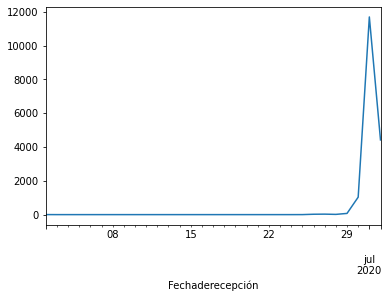

In [57]:
# BD.RUT.isin(BD_Minsal.RUT).value_counts()
BD_Minsal.groupby(pd.Grouper(key='Fechaderecepción', freq='D')).Fechaderecepción.count().plot()